# Car Classification Model Training

This notebook trains a Hybrid ResNet-ViT model for Indonesian car classification using the collected dataset. The model combines ResNet-50 as a feature extractor with a Vision Transformer for classification.

## Dataset Structure
- **Classes**: 8 Indonesian car types (hatchback, mpv, offroad, pickup, sedan, suv, truck, van)
- **Architecture**: Hybrid ResNet-ViT combining CNN and Transformer
- **Training Strategy**: Transfer learning with data augmentation
- **Class Imbalance**: Handled using weighted loss function for better minority class performance

## Training Process
1. Dataset exploration and class imbalance analysis
2. Model training with weighted loss and comprehensive tracking
3. Performance analysis with detailed charts and metrics
4. Model evaluation with per-class analysis and confusion matrix
5. Training insights and recommendations for optimization

In [1]:
!rm -rf /kaggle/working
!git clone https://github.com/luthfiarifin/Hybrid-RViT-Car-Retrieval.git code
!mv code/* .
!ls

rm: cannot remove '/kaggle/working': Device or resource busy
Cloning into 'code'...
remote: Enumerating objects: 66228, done.
remote: Counting objects: 100% (23260/23260), done.
remote: Compressing objects: 100% (23259/23259), done.
remote: Total 66228 (delta 2), reused 23255 (delta 1), pack-reused 42968 (from 2)
Receiving objects: 100% (66228/66228), 3.11 GiB | 20.36 MiB/s, done.
Resolving deltas: 100% (356/356), done.
Updating files: 100% (28853/28853), done.
1_run_scraper_into_dataset.ipynb	code		 models
2_train_the_classification_model.ipynb	data_processing


In [2]:
# Import required libraries
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import os
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

# Set style for plots
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(
        f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB"
    )

Libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB
CUDA memory: 15.9 GB


2025-06-23 10:33:28.284088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750674808.460781      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750674808.510709      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===
Using device: cuda
Logging to TensorBoard: logs/train_classification/run_1750674823


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 226MB/s]


Using weighted CrossEntropyLoss with weights: tensor([0.7266, 0.7455, 0.6201, 1.0684, 1.4679, 0.9564, 3.2744, 1.4258],
       device='cuda:0')

📊 Class Distribution Analysis:
Class        Count    Percentage Imbalance Ratio
--------------------------------------------------
crossover    3966     17.2      % 1.17           x
hatchback    3865     16.8      % 1.20           x
mpv          4647     20.2      % 1.00           x
offroad      2697     11.7      % 1.72           x
pickup       1963     8.5       % 2.37           x
sedan        3013     13.1      % 1.54           x
truck        880      3.8       % 5.28           x
van          2021     8.8       % 2.30           x

📈 Imbalance Factor: 5.28x (Most frequent / Least frequent)
⚠️  High imbalance detected! Consider using weighted loss or resampling.
Trainer initialized successfully!
Training samples: 23052
Validation samples: 2881
Number of batches per epoch: 361
Class names: ['crossover', 'hatchback', 'mpv', 'offroad', 'pickup', 

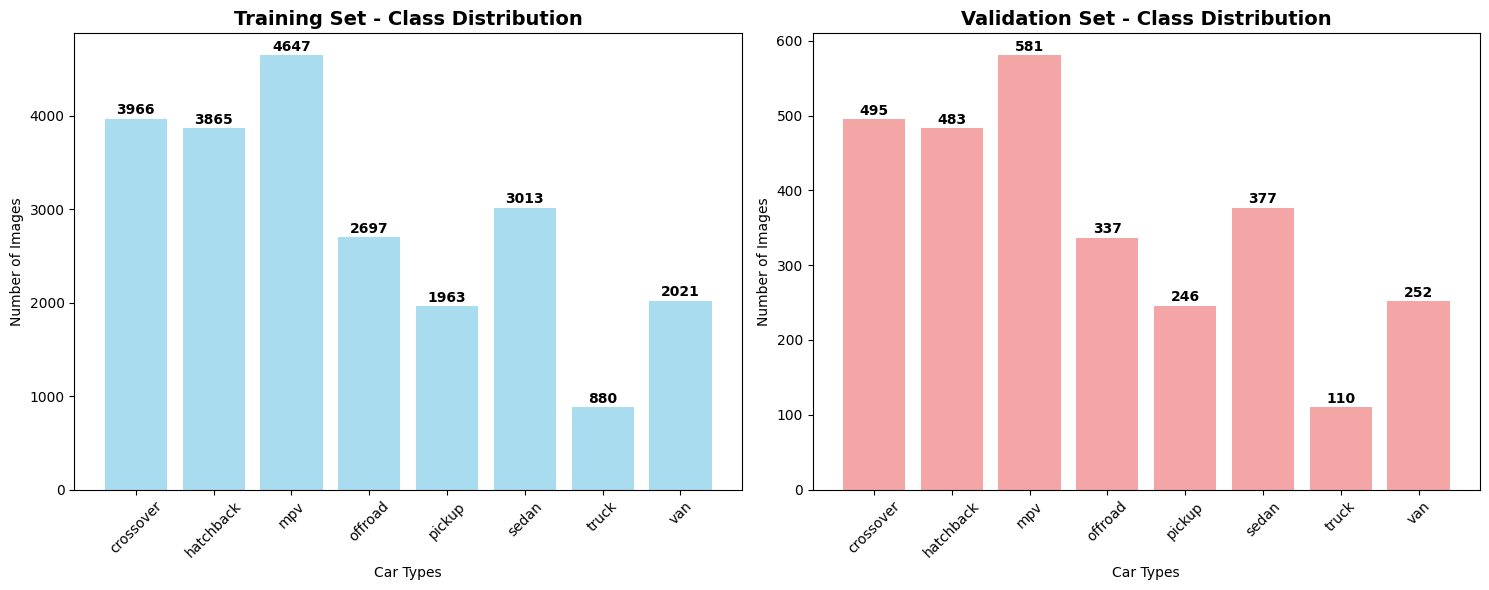


=== Dataset Summary ===
    Class  Training  Validation  Total  Train_Ratio
crossover      3966         495   4461        0.889
hatchback      3865         483   4348        0.889
      mpv      4647         581   5228        0.889
  offroad      2697         337   3034        0.889
   pickup      1963         246   2209        0.889
    sedan      3013         377   3390        0.889
    truck       880         110    990        0.889
      van      2021         252   2273        0.889


In [3]:
# Training configuration

from models.classification.train_classification import CarClassifierTrainer

CONFIG = {
    "train_dir": "data_processing/data/dataset/train",
    "val_dir": "data_processing/data/dataset/val",
    "num_classes": 8,
    "embed_dim": 768,
    "num_heads": 12,
    "num_layers": 6,
    "dropout": 0.1,
    "learning_rate": 1e-4,
    "batch_size": 64,
    "num_epochs": 25,
    "result_path": f'models/results/carvit_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth',
    "use_weighted_loss": True,
    "use_class_balancing": False,
    "num_workers": 8,
    "early_stopping_patience": 7,
    "early_stopping_delta": 0.001,
    "early_stopping_verbose": True,
}

# Initialize the trainer with class imbalance handling and early stopping
print("\n=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===")
trainer = CarClassifierTrainer(
    train_dir=CONFIG["train_dir"],
    val_dir=CONFIG["val_dir"],
    num_classes=CONFIG["num_classes"],
    embed_dim=CONFIG["embed_dim"],
    num_heads=CONFIG["num_heads"],
    num_layers=CONFIG["num_layers"],
    dropout=CONFIG["dropout"],
    learning_rate=CONFIG["learning_rate"],
    batch_size=CONFIG["batch_size"],
    num_epochs=CONFIG["num_epochs"],
    result_path=CONFIG["result_path"],
    use_weighted_loss=CONFIG["use_weighted_loss"],
    use_class_balancing=CONFIG["use_class_balancing"],
    num_workers=CONFIG["num_workers"],
    early_stopping_patience=CONFIG["early_stopping_patience"],
    early_stopping_delta=CONFIG["early_stopping_delta"],
    early_stopping_verbose=CONFIG["early_stopping_verbose"],
)

print("Trainer initialized successfully!")
print(f"Training samples: {len(trainer.train_dataset)}")
print(f"Validation samples: {len(trainer.val_dataset)}")
print(f"Number of batches per epoch: {len(trainer.train_loader)}")
print(f"Class names: {trainer.train_dataset.classes}")

from models.classification.training_report import TrainingReport

# Create a training report instance
report = TrainingReport(trainer, CONFIG, None)

# Generate and summary report
report.dataset_summary_report()

In [4]:
# Start training with detailed tracking
start_time = time.time()

# Execute training
training_results = trainer.train()

# Print training results
total_time = time.time() - start_time
print(f"\n=== Training Completed in {total_time:.2f} seconds ===")

Starting training with detailed tracking and early stopping...
Early Stopping - Patience: 7, Delta: 0.001
Model parameters: 143,116,360
Trainable parameters: 143,116,360

Epoch 1/25


100%|██████████| 361/361 [03:54<00:00,  1.54it/s, loss=1.33] 


Validation accuracy: 74.77%
Validation loss: 0.7448
Time: 247.01s | LR: 1.00e-04
🎉 New best accuracy: 74.77%
Validation loss decreased (inf --> 0.744752).  Saving model ...

Epoch 2/25


100%|██████████| 361/361 [03:54<00:00,  1.54it/s, loss=0.25] 


Validation accuracy: 79.94%
Validation loss: 0.6444
Time: 247.40s | LR: 1.00e-04
🎉 New best accuracy: 79.94%
Validation loss decreased (0.744752 --> 0.644355).  Saving model ...

Epoch 3/25


100%|██████████| 361/361 [03:54<00:00,  1.54it/s, loss=0.153]


Validation accuracy: 83.44%
Validation loss: 0.5153
Time: 247.02s | LR: 1.00e-04
🎉 New best accuracy: 83.44%
Validation loss decreased (0.644355 --> 0.515259).  Saving model ...

Epoch 4/25


100%|██████████| 361/361 [03:52<00:00,  1.55it/s, loss=0.257]


Validation accuracy: 86.01%
Validation loss: 0.4758
Time: 245.67s | LR: 1.00e-04
🎉 New best accuracy: 86.01%
Validation loss decreased (0.515259 --> 0.475806).  Saving model ...

Epoch 5/25


100%|██████████| 361/361 [03:50<00:00,  1.56it/s, loss=1.3]   


Validation accuracy: 85.91%
Validation loss: 0.4591
Time: 243.42s | LR: 1.00e-04
Validation loss decreased (0.475806 --> 0.459055).  Saving model ...

Epoch 6/25


100%|██████████| 361/361 [03:52<00:00,  1.55it/s, loss=0.225]


Validation accuracy: 85.91%
Validation loss: 0.4618
Time: 244.92s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 7/25


100%|██████████| 361/361 [03:51<00:00,  1.56it/s, loss=0.226] 


Validation accuracy: 86.71%
Validation loss: 0.4601
Time: 243.94s | LR: 1.00e-04
🎉 New best accuracy: 86.71%
EarlyStopping counter: 2 out of 7

Epoch 8/25


100%|██████████| 361/361 [03:51<00:00,  1.56it/s, loss=0.419] 


Validation accuracy: 88.30%
Validation loss: 0.4723
Time: 244.36s | LR: 1.00e-04
🎉 New best accuracy: 88.30%
EarlyStopping counter: 3 out of 7

Epoch 9/25


100%|██████████| 361/361 [03:51<00:00,  1.56it/s, loss=0.412] 


Validation accuracy: 88.13%
Validation loss: 0.4376
Time: 244.05s | LR: 1.00e-04
Validation loss decreased (0.459055 --> 0.437589).  Saving model ...

Epoch 10/25


100%|██████████| 361/361 [03:50<00:00,  1.57it/s, loss=0.083] 


Validation accuracy: 87.82%
Validation loss: 0.5182
Time: 243.32s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 11/25


100%|██████████| 361/361 [03:49<00:00,  1.57it/s, loss=0.384] 


Validation accuracy: 88.65%
Validation loss: 0.4408
Time: 242.57s | LR: 1.00e-04
🎉 New best accuracy: 88.65%
EarlyStopping counter: 2 out of 7

Epoch 12/25


100%|██████████| 361/361 [03:49<00:00,  1.57it/s, loss=0.587] 


Validation accuracy: 90.04%
Validation loss: 0.4280
Time: 242.87s | LR: 1.00e-04
🎉 New best accuracy: 90.04%
Validation loss decreased (0.437589 --> 0.428008).  Saving model ...

Epoch 13/25


100%|██████████| 361/361 [03:51<00:00,  1.56it/s, loss=0.186] 


Validation accuracy: 88.82%
Validation loss: 0.4513
Time: 244.30s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 14/25


100%|██████████| 361/361 [03:53<00:00,  1.54it/s, loss=0.0865]


Validation accuracy: 89.03%
Validation loss: 0.4755
Time: 246.79s | LR: 1.00e-04
EarlyStopping counter: 2 out of 7

Epoch 15/25


100%|██████████| 361/361 [03:51<00:00,  1.56it/s, loss=0.517] 


Validation accuracy: 87.68%
Validation loss: 0.4838
Time: 244.93s | LR: 1.00e-04
EarlyStopping counter: 3 out of 7

Epoch 16/25


100%|██████████| 361/361 [03:57<00:00,  1.52it/s, loss=0.257] 


Validation accuracy: 88.27%
Validation loss: 0.4919
Time: 250.20s | LR: 1.00e-04
EarlyStopping counter: 4 out of 7

Epoch 17/25


100%|██████████| 361/361 [03:54<00:00,  1.54it/s, loss=0.047] 


Validation accuracy: 89.62%
Validation loss: 0.4632
Time: 247.46s | LR: 1.00e-04
EarlyStopping counter: 5 out of 7

Epoch 18/25


100%|██████████| 361/361 [03:54<00:00,  1.54it/s, loss=0.158] 


Validation accuracy: 88.34%
Validation loss: 0.5021
Time: 246.78s | LR: 1.00e-04
EarlyStopping counter: 6 out of 7

Epoch 19/25


100%|██████████| 361/361 [03:54<00:00,  1.54it/s, loss=0.344] 


Validation accuracy: 88.44%
Validation loss: 0.4737
Time: 247.60s | LR: 1.00e-04
EarlyStopping counter: 7 out of 7

🛑 Early stopping triggered at epoch 19
Best validation loss: 0.428008

Training completed!
Training stopped early at epoch 19 due to no improvement in validation loss
Best validation accuracy: 90.04%
Loading best model with validation loss: 0.428008
Best accuracy model saved to models/results/carvit_model_20250623_103343_best_acc.pth

=== Training Completed in 4675.98 seconds ===


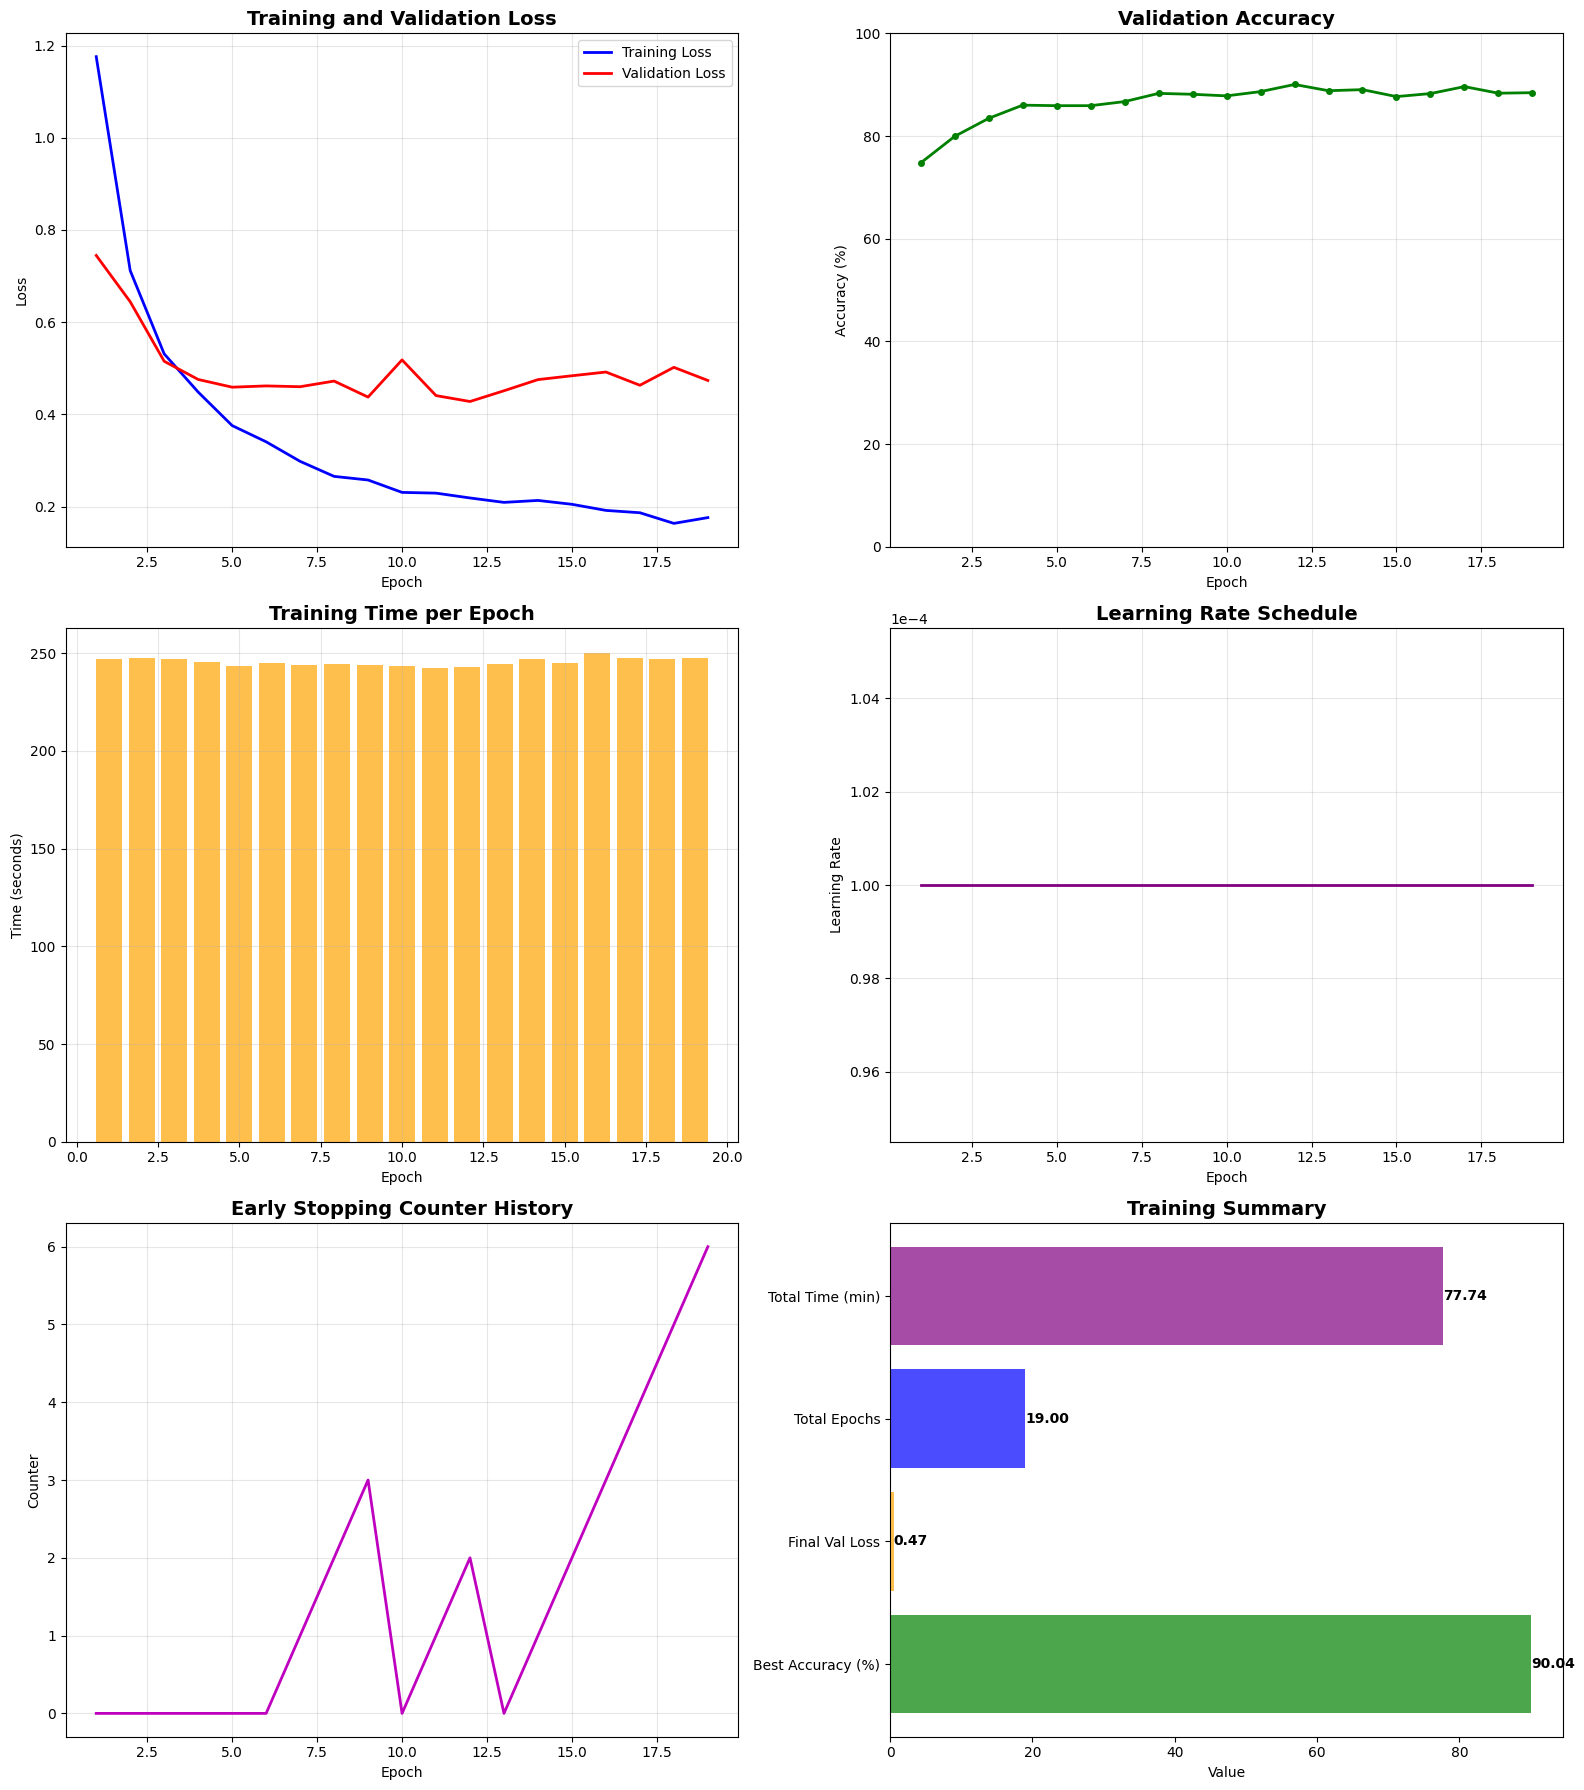


🛑 Early Stopping Analysis:
Early stopping triggered at epoch 19/25.
Epochs saved: 6
Time saved: ~24.6 minutes
Efficiency gain: 24.0%

📈 Detailed Training Statistics:
- Loss Reduction: 1.1759 → 0.1762 (85.0% improvement)
- Best Accuracy: 90.04% (Epoch 12)
- Total Training Time: 77.74 minutes
- Average Time per Epoch: 245.51s
- Fastest Epoch: 242.57s
- Slowest Epoch: 250.20s
- Early Stopping Counter History: [0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 3, 4, 5, 6]

📋 Training Metrics Table (Last 5 Epochs):
 Epoch  Train_Loss  Val_Loss  Val_Accuracy  Epoch_Time  Learning_Rate  ES_Counter
    15      0.2050    0.4838         87.68      244.93         0.0001           2
    16      0.1918    0.4919         88.27      250.20         0.0001           3
    17      0.1867    0.4632         89.62      247.46         0.0001           4
    18      0.1637    0.5021         88.34      246.78         0.0001           5
    19      0.1762    0.4737         88.44      247.60         0.0001         

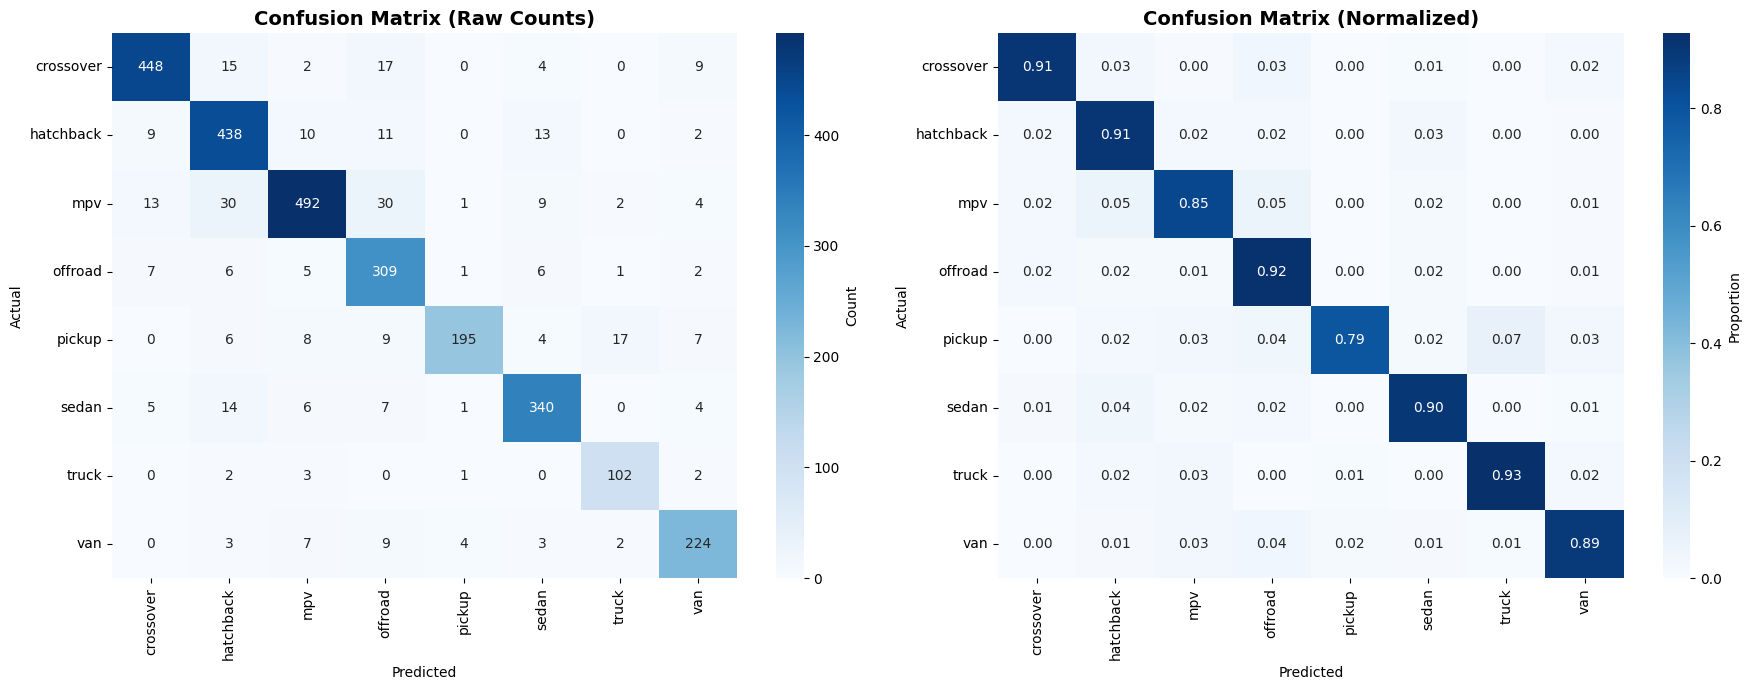


📊 Detailed Classification Report:
              precision    recall  f1-score   support

   crossover     0.9295    0.9051    0.9171       495
   hatchback     0.8521    0.9068    0.8786       483
         mpv     0.9231    0.8468    0.8833       581
     offroad     0.7883    0.9169    0.8477       337
      pickup     0.9606    0.7927    0.8686       246
       sedan     0.8971    0.9019    0.8995       377
       truck     0.8226    0.9273    0.8718       110
         van     0.8819    0.8889    0.8854       252

    accuracy                         0.8844      2881
   macro avg     0.8819    0.8858    0.8815      2881
weighted avg     0.8889    0.8844    0.8848      2881


⚖️ Class Imbalance Impact Analysis:

📈 Class Group Performance:
Minority Classes (4): ['offroad', 'pickup', 'truck', 'van']
Average Accuracy: 88.14%
Majority Classes (4): ['crossover', 'hatchback', 'mpv', 'sedan']
Average Accuracy: 89.01%
Performance Gap: 0.87% (Majority better)


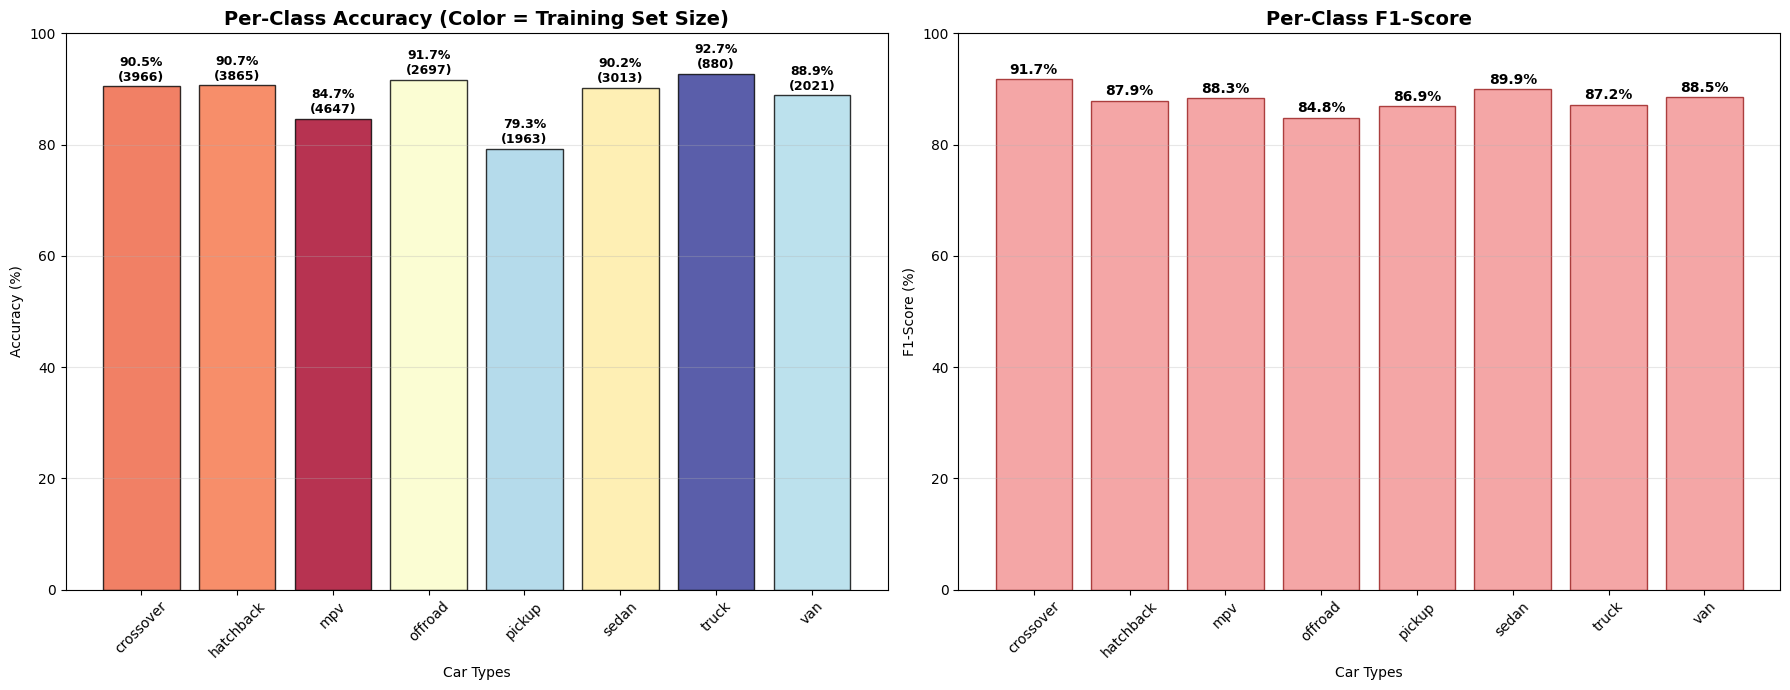


🛑 Early stopping summary saved to: models/classification/reports/early_stopping_summary_20250623_115826.json

💾 Training history saved to: models/classification/reports/training_history_20250623_115826.csv
📊 Class performance saved to: models/classification/reports/class_performance_20250623_115826.csv
🎯 Best model saved to: models/results/carvit_model_20250623_103343.pth
🏆 Best accuracy model saved to: models/results/carvit_model_20250623_103343_best_acc.pth

🎉 Training Analysis Complete!
🎯 Final Summary:
- Training completed in 19 epochs (planned: 25)
- Best validation accuracy: 90.04%
- Early stopping: Activated
- Total training time: 77.74 minutes
- Time saved by early stopping: 24.6 minutes
- Class imbalance: High (ratio: 5.28x)
- Model saved with best validation loss: 0.428008


In [5]:
report = TrainingReport(trainer, CONFIG, training_results)

# Generate the full report
report.full_report()

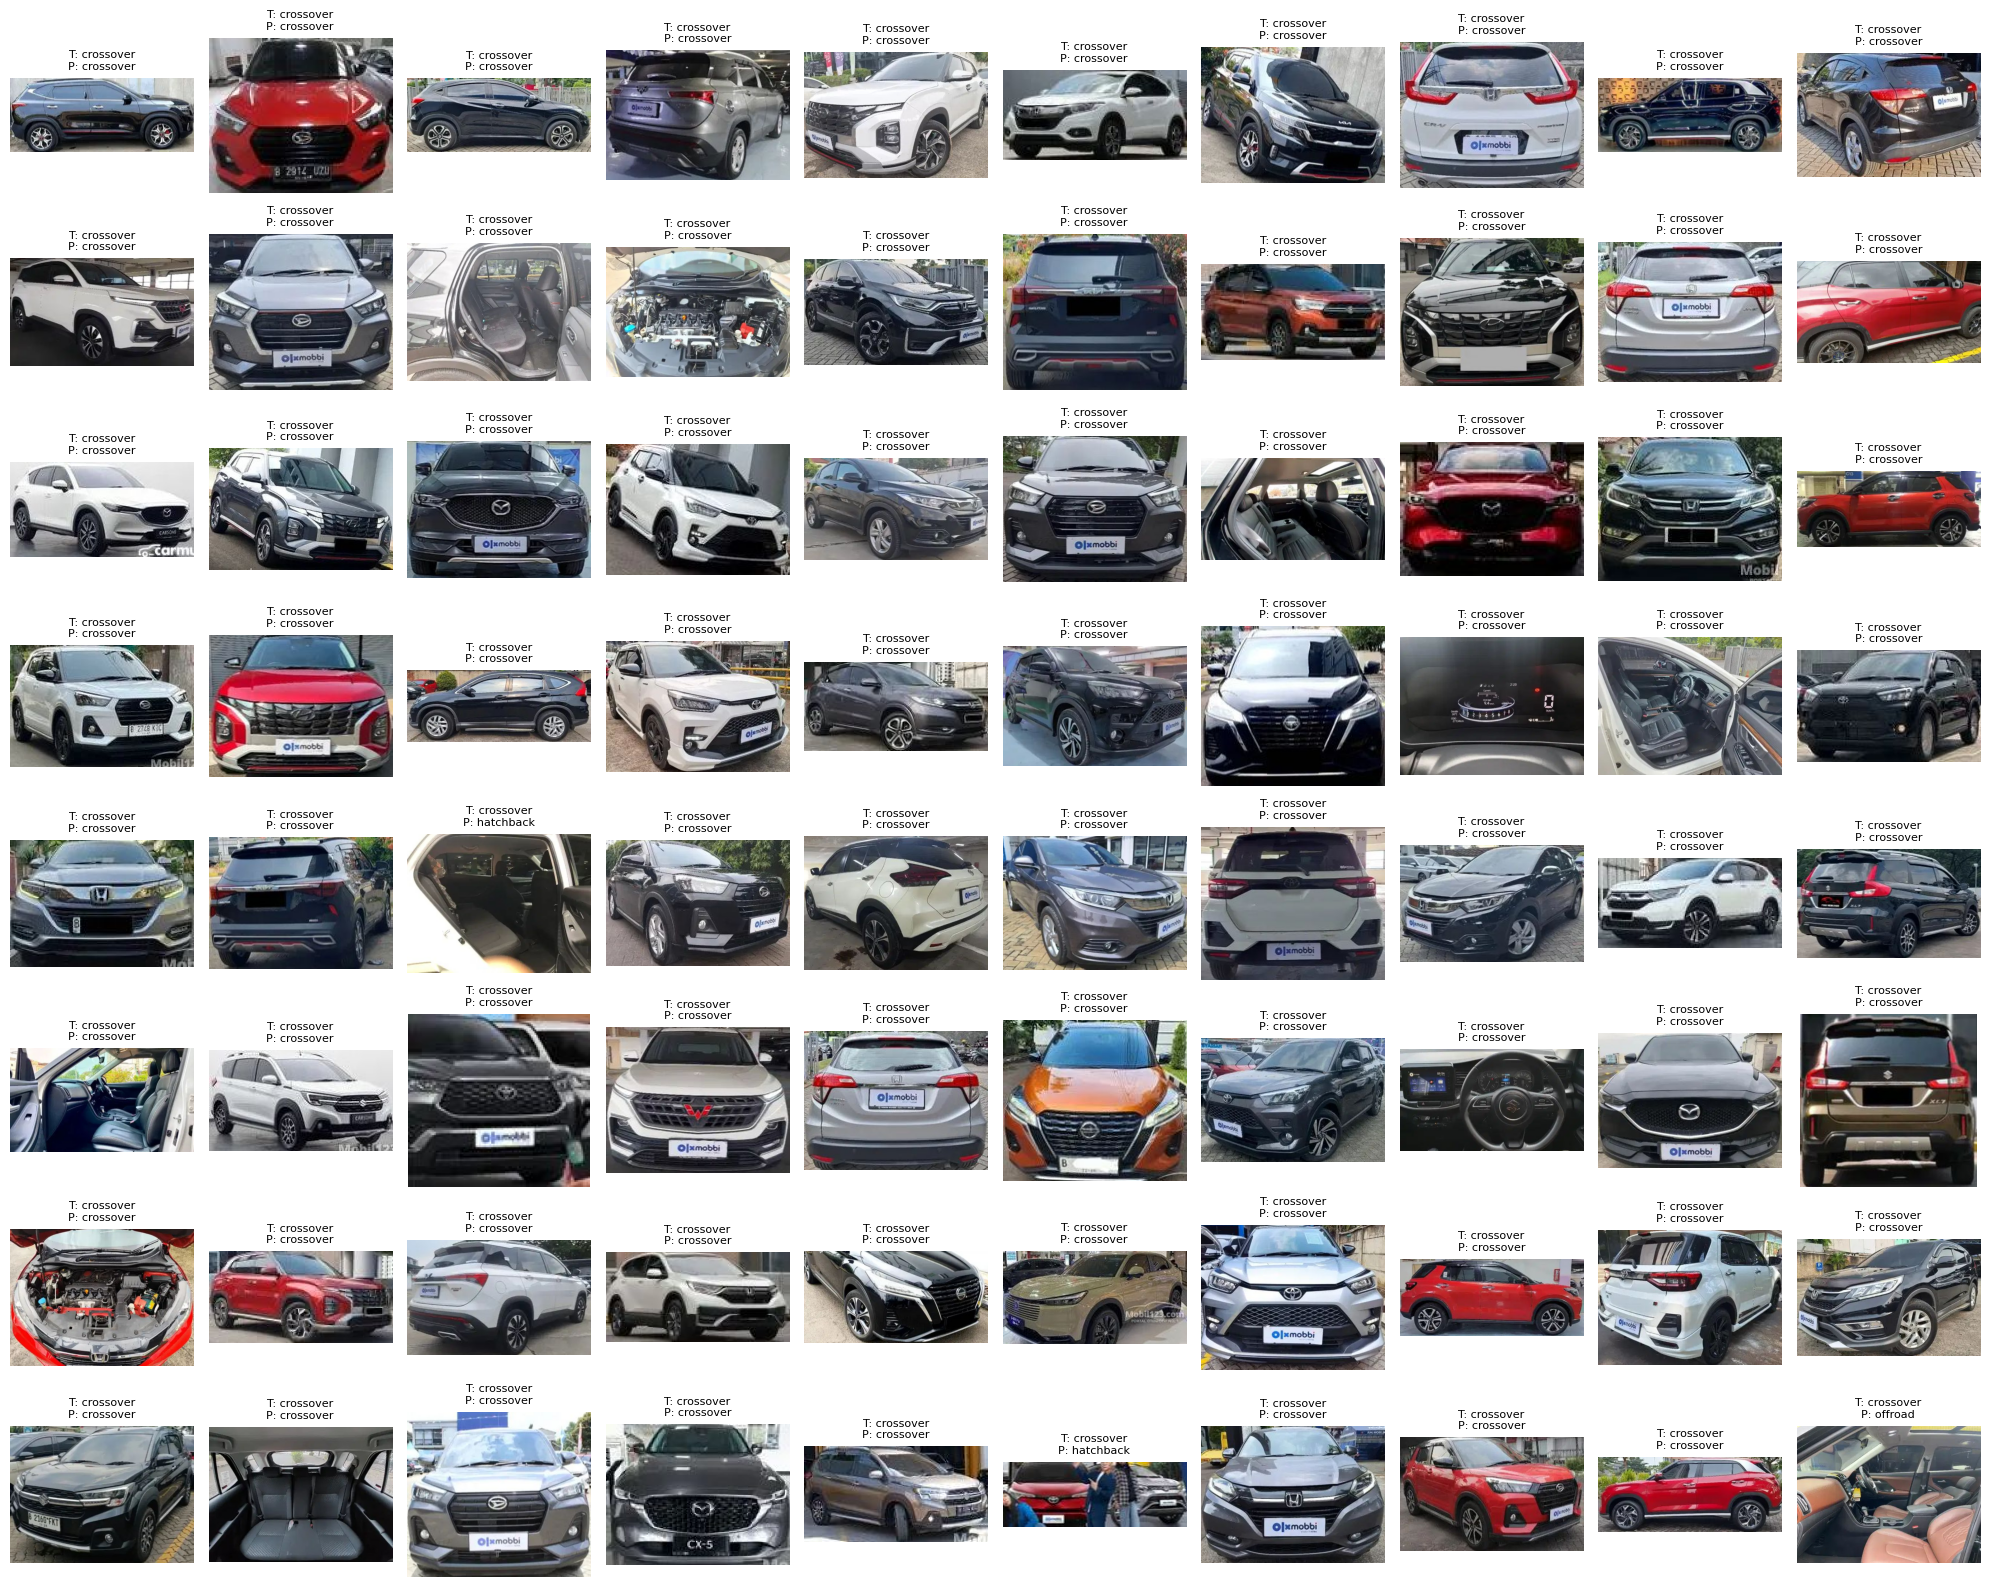

In [6]:
# Test the classification model test images and display predictions
from models.classification.test_classification import CarClassificationTester

test_dir = "data_processing/data/dataset/test"
class_names = [
    d for d in sorted(os.listdir(test_dir)) if os.path.isdir(os.path.join(test_dir, d))
]
tester = CarClassificationTester(
    test_dir=test_dir,
    class_names=class_names,
    model_path=None,
    num_classes=len(class_names),
    grid_rows=8,
    grid_cols=10,
    img_size=224,
    embed_dim=768,
    num_heads=12,
    num_layers=6,
    dropout=0.1,
)

tester.plot_predictions()